In [1]:
import sklearn.datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from sklearn.metrics import r2_score
%matplotlib inline
dat= sklearn.datasets.load_boston()
boston=pd.DataFrame(dat["data"],columns=dat["feature_names"])
boston=pd.concat([boston,pd.DataFrame(dat["target"],columns=["price"])],axis=1)
iris=sklearn.datasets.load_iris()
iris=pd.concat([pd.DataFrame([iris.target_names[x] for x in iris.target],columns=["species"]),pd.DataFrame(iris["data"],columns=iris["feature_names"])],axis=1)

In [2]:
def dataquality(df,granulo=10):
    """
    Calculation of a data quality score
    :param granulo:segmentation for continuous data
    
    """
    totalcell=df.shape[0]*df.shape[1]
    isnotna=1-df.isna().sum().sum()/totalcell
    res=[["Completeness",round(isnotna*100,0)]]
    for col,typ in zip(df.columns,df.dtypes):

        if typ=="object":

            valeurs=df[col].value_counts()
            maxecartO=df.shape[0]-2+(len(valeurs)-2)*df.shape[0]/len(valeurs)
            ecarts=np.abs(valeurs-valeurs.sum()/len(valeurs)).sum()/maxecartO
            res.append([col,round(100-ecarts*100,0)])


        else:
            if typ=="float64" or typ=="int64":

                maxecartF=df.shape[0]-2+(granulo-2)*df.shape[0]/granulo
                maxx=df[col].max()
                minn=df[col].min()
                cnt=[]
                for x in range(granulo+1):
                    ma=minn+(maxx-minn)/granulo*x
                    cnt.append(len(df[col][(df[col]>=ma) & (df[col]<ma+(maxx-minn)/granulo)]))
                ecarts=np.array(cnt).sum()/maxecartF
                res.append([col,round(100-ecarts*100,0)])
    res=pd.DataFrame(res,columns=["Feature","Quality"])
    res=res.append({"Feature":"Trainability","Quality":round(100-df.shape[1]/df.shape[0]*100,0)},ignore_index=True)
    res=res.append({"Feature":"Global quality (%)","Quality":round(res["Quality"].mean())},ignore_index=True)
        
    return res



# DQS on iris case

In [3]:
dataquality(iris)

,Feature,Quality
0,Completeness,100.0
1,species,100.0
2,sepal length (cm),42.0
3,sepal width (cm),44.0
4,petal length (cm),44.0
5,petal width (cm),44.0
6,Trainability,97.0
7,Global quality (%),67.0


# DQS on Boston case

In [4]:
dataquality(boston)

,Feature,Quality
0,Completeness,100.0
1,CRIM,44.0
2,ZN,44.0
3,INDUS,44.0
4,CHAS,44.0
5,NOX,44.0
6,RM,44.0
7,AGE,44.0
8,DIS,44.0
9,RAD,44.0


In [5]:
res=[]
for g in [3,4,5,6,7,10,20,100]:
    res.append([g]+dataquality(boston,granulo=g).Quality.to_list()[1:-2])
res=pd.DataFrame(res,columns=["granulo"]+boston.columns.to_list())

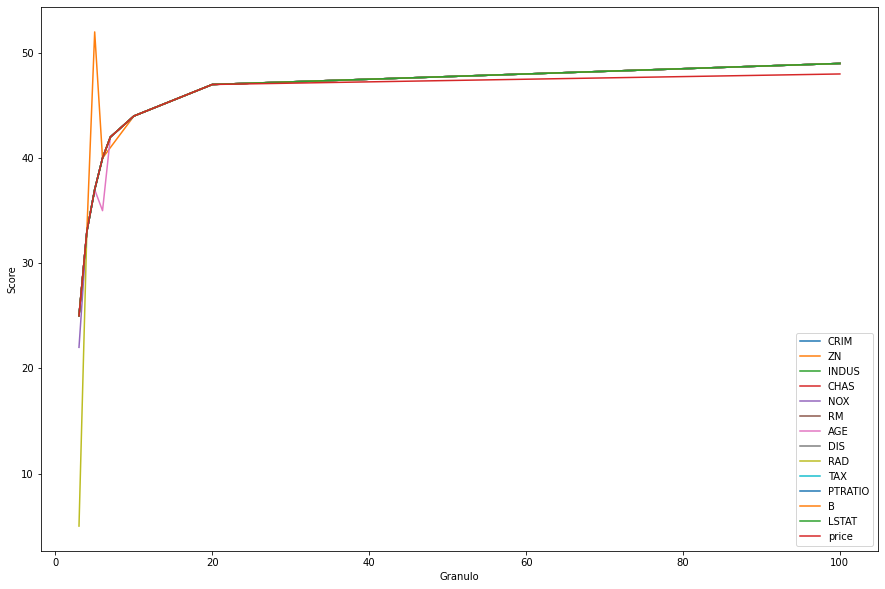

In [6]:
plt.figure(figsize=(15,10))
for Y in boston.columns:
    plt.plot(res.granulo,res[Y],label=Y)
plt.xlabel("Granulo")
plt.ylabel("Score")
plt.legend()

# Normal law

In [7]:
df=np.random.normal(3, 2.5, size=(1000, 2))
df=pd.DataFrame(df,columns=['V1','V2'])
dataquality(df,granulo=500)

,Feature,Quality
0,Completeness,100.0
1,V1,50.0
2,V2,50.0
3,Trainability,100.0
4,Global quality (%),75.0


# Benford's law
On Boston case
https://en.wikipedia.org/wiki/Benford%27s_law

In [8]:
def benfordslaw(df,centered=False):
    """
    Calculation of Benford's law
    
    """
    res=[]
    cols=[]
    ben=[0 for _ in range(9)]
    for col,typ in zip(df.columns,df.dtypes):
        if typ!="object":
            maxi,mini=df[col].abs().max(),df[col].abs().min()
            cols.append(col)
            if centered:
                c=(df[col].abs()-mini)/(maxi-mini)*1000
            else:
                c=df[col].abs()*1000
            c=c.to_numpy().astype(int).astype(str)
            
            
            
            for x in c:
                if x[0]!='0':
                    ben[int(x[0])-1]+=1
    ben=np.array(ben)/sum(ben)
    res.append(ben)
    res=np.array(res)
    res=res.reshape(9,res.shape[0])
    res=pd.DataFrame(res,index=[i+1 for i in range(9)],columns=["p"])
    res["Benford"]=[np.log10(1+1/x) for x in res.index]
    r2=r2_score(res.p,res.Benford)
    return res,r2

In [15]:
res,r2=benfordslaw(boston,centered=False)

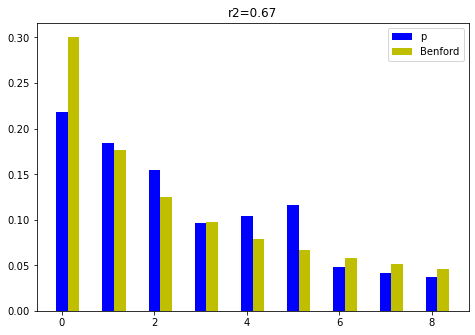

In [16]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.arange(9)
ax.bar(X + 0.00, res.p, color = 'b', width = 0.25)
ax.bar(X + 0.25, res.Benford, color = 'y', width = 0.25)
ax.legend(labels=res.columns)
plt.title(f"r2={r2:.2}")
plt.show()